In [3]:
import numpy as np 
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime

%matplotlib inline     
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from matplotlib.pylab import rcParams

from timeseries.utils import *
from timeseries.plot import *
from timeseries.model import *

# Register converters to avoid warnings
pd.plotting.register_matplotlib_converters()
plt.rc("figure", figsize=(10,6))
plt.rc("font", size=13)

In this tutorial we provide some basics on time series so you can go further exploring different types of time series properties and model used for forecasting

This tutorial is divided in 2 notebooks:

* [01-intro-time-series.ipynb]()
* [02-SARIMAX-model.ipynb]()

<a class="anchor" id="0.1"></a>
# **Table of Contents**

# **1. Introduction to Time Series** <a class="anchor" id="1"></a>

Time series analysis deals with data that is ordered in time. Time series data is one of the most common data types and it is used in a wide variety of domains: finance, climate, health, energy, governance, industry, agriculture, business etc. Being able to effectively work with such data is an increasingly important skill for data scientists, especially when the goal is to report trends, forecast, and even detect anomalies.

In [2]:
file = 'input/sale_values.csv'
df = pd.read_csv(file)
df = process_data(df)
df.head(5)

,index,Period,Revenue,Sales_quantity,Average_cost,The_average_annual_payroll_of_the_region,Date
0,0,01.01.2015,1.601007e+07,12729.0,1257.763541,30024676.0,2015-01-01
1,1,01.02.2015,1.580759e+07,11636.0,1358.507000,30024676.0,2015-02-01
2,2,01.03.2015,2.204715e+07,15922.0,1384.697024,30024676.0,2015-03-01
3,3,01.04.2015,1.881458e+07,15227.0,1235.606705,30024676.0,2015-04-01
4,4,01.05.2015,1.402148e+07,8620.0,1626.621765,30024676.0,2015-05-01


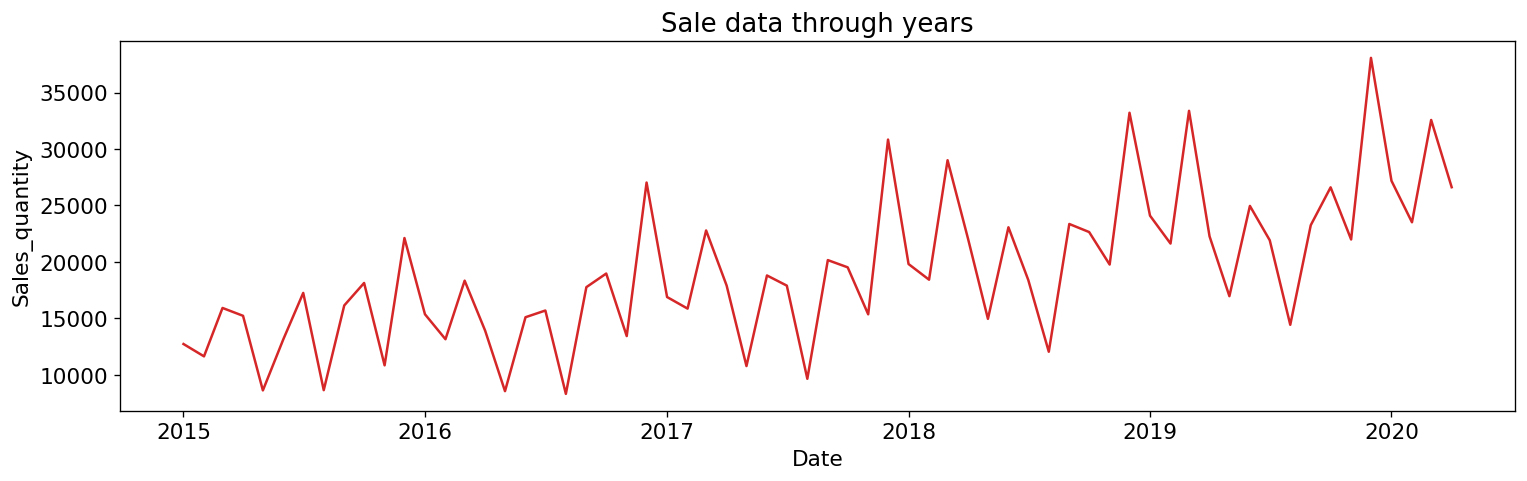

In [3]:
plain_plot(df, title = "Sale data through years")

# **1.1 Box-Jenkins Method** <a class="anchor" id="3"></a>

To learn applying (S)ARIMA(X) models we will follow some steps based on [Box-Jenkins Method](https://en.wikipedia.org/wiki/Box%E2%80%93Jenkins_method). This popular framework provides a systematic way that involves getting to know your data and applying the appropriate methods to choose parameters that will lead to a good model.

![Box-Jenkins-Method](images\Box-Jenkins-Method.png)
## STEP 1 - Identify

Following the schema above in this step we use tools to identify characteristics of the time series so we can build an appropriate model. 

Here we search for answers for questions such as:
* _Is the time series seasonal?_

* _If seasonal what is the seasonal period?_

* _Is the time series stationary?_
    
* _If not stationary, which transformation should we apply to make it stationary?_

### Visualize times series sales data

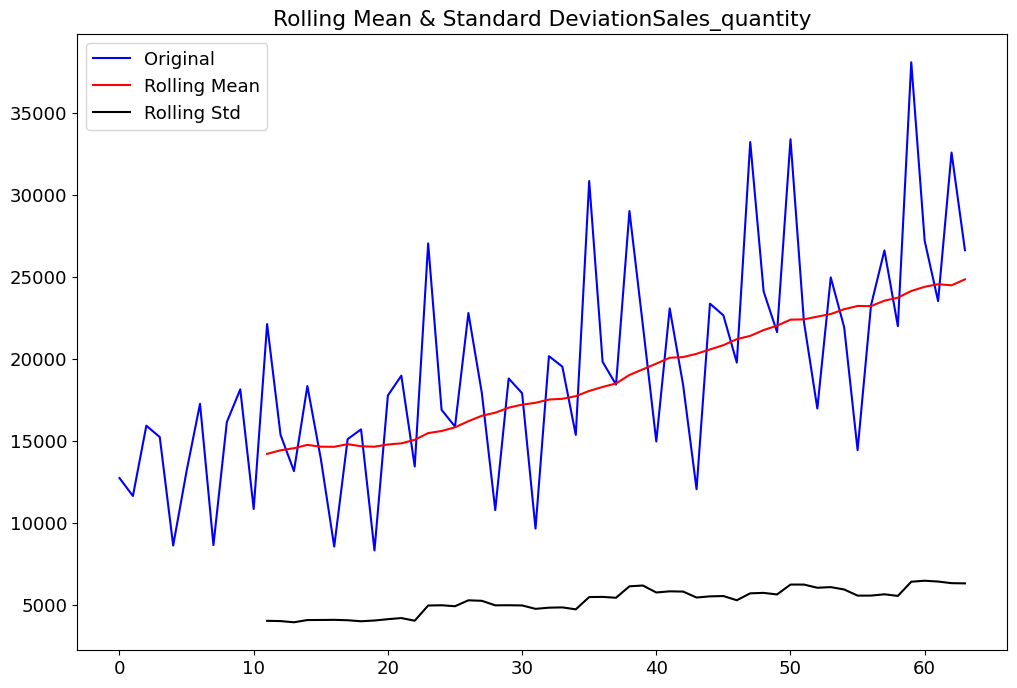

In [4]:
rolling_statistics_graph(df.dropna(),columnname="Sales_quantity")

# **2. Components of Time Series and Time Series Properties - Trend and Seasonal** <a class="anchor" id="2"></a>

In general, most time series can be decomposed in three major components: trend, seasonality, and noise.

**`trend`** shows whether the series is consistently decreasing (downward trend), constant (no trend) or increasing (upward trend) over time.

**`seasonality`** describes the periodic signal in your time series. A seasonal time series typically exhibits a strong correlation with its lagged values at multiples of the seasonal period

**`noise`** or **`residual`** displays the unexplained variance and volatility of the time series.

We can easily access those components applying Python’s statsmodels library seasonal_decompose.

## 2.1 Time Series Properties
Time series components help us recognizing some of important properties such as `seasonality`, ` cyclicality `, `stationarity`, and whether the time series is `additive` or `multiplicative`.  Throughout this tutorial, you will learn how recognizing and understanding such properties is essential in the process of building a successful forecasting model.

### 2.1.1 Seasonality x Cyclicality

By observing the seasonal component, we can say if the time series is `seasonal` or `cyclic`. `Seasonality` should always present a fixed and known period. If there is no fixed or known period, we are observing a cyclic signal, i.e., ` cyclicality`.


### 2.1.2 Additive / Multiplicative Model

As seen previously a time series is a combination of its components: trend, seasonal, and residual components. This combination can occur either in an additive or multiplicative way.

#### 2.1.1 Additive Model
An additive model suggests that the components are added together as follows:
$$ Y(t) = Level + Trend + Seasonality + Noise$$

An additive model is linear where changes over time are consistently made by the same amount.
A linear trend is a straight line.
A linear seasonality has the same frequency (width of cycles) and amplitude (height of cycles).

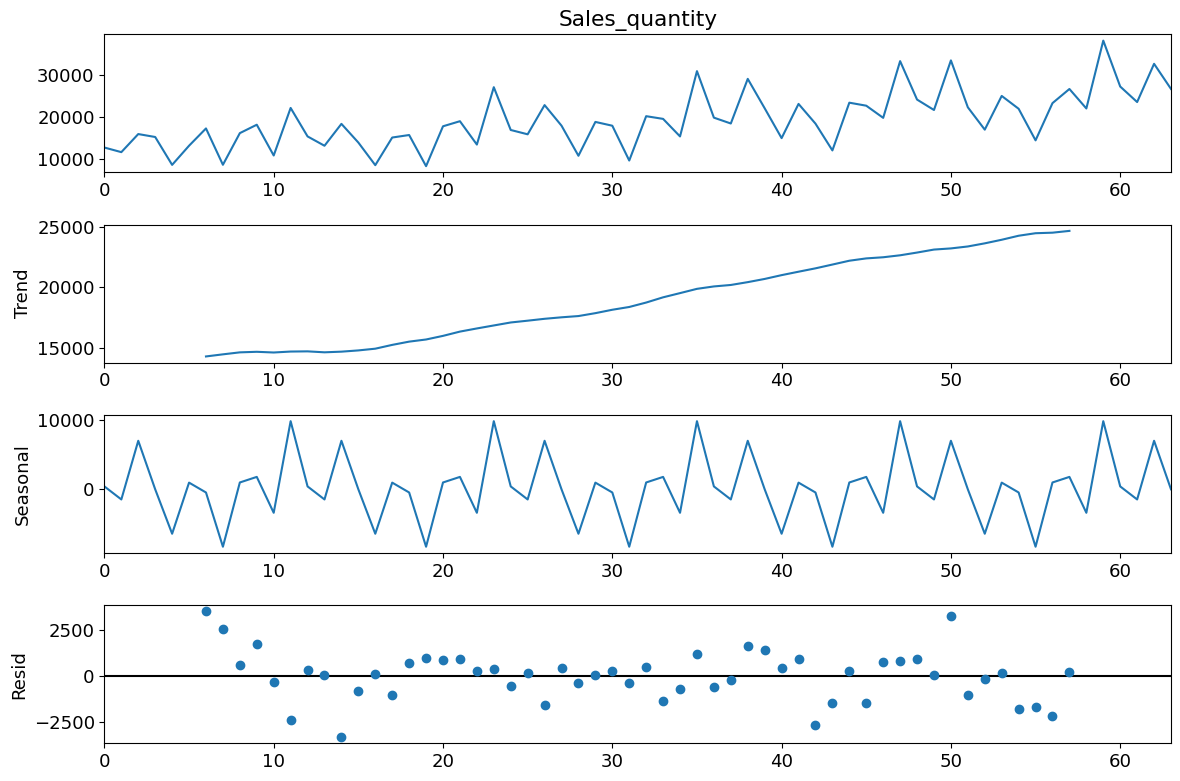

In [5]:
# Using statmodels: Subtracting the Trend Component
from statsmodels.tsa.seasonal import seasonal_decompose
add_result = seasonal_decompose(df['Sales_quantity'].dropna(), model='additive', period=12)
add_result.plot()
plt.show()

<AxesSubplot: >

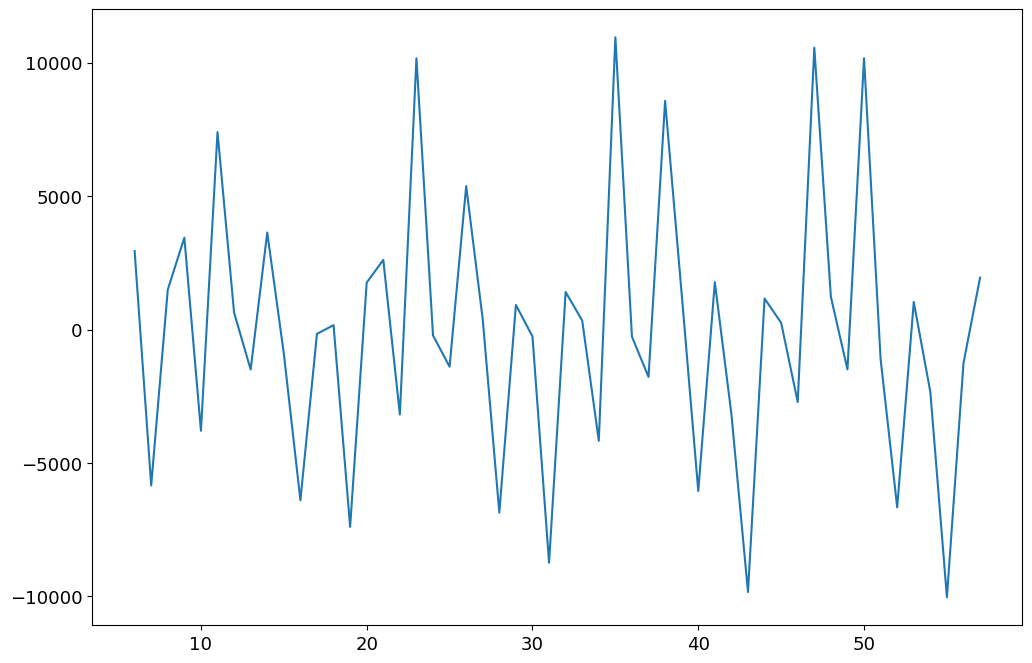

In [6]:
add_detrended = df['Sales_quantity'].dropna().values - add_result.trend
add_detrended.plot()

### 2.1.2 Multiplicative Model
A multiplicative model suggests that the components are multiplied together as follows:
$$
Y(t) = Level * Trend * Seasonality * Noise
$$
A multiplicative model is nonlinear, such as quadratic or exponential. Changes increase or decrease over time.
A nonlinear trend is a curved line.
A non-linear seasonality has an increasing or decreasing frequency and/or amplitude over time.

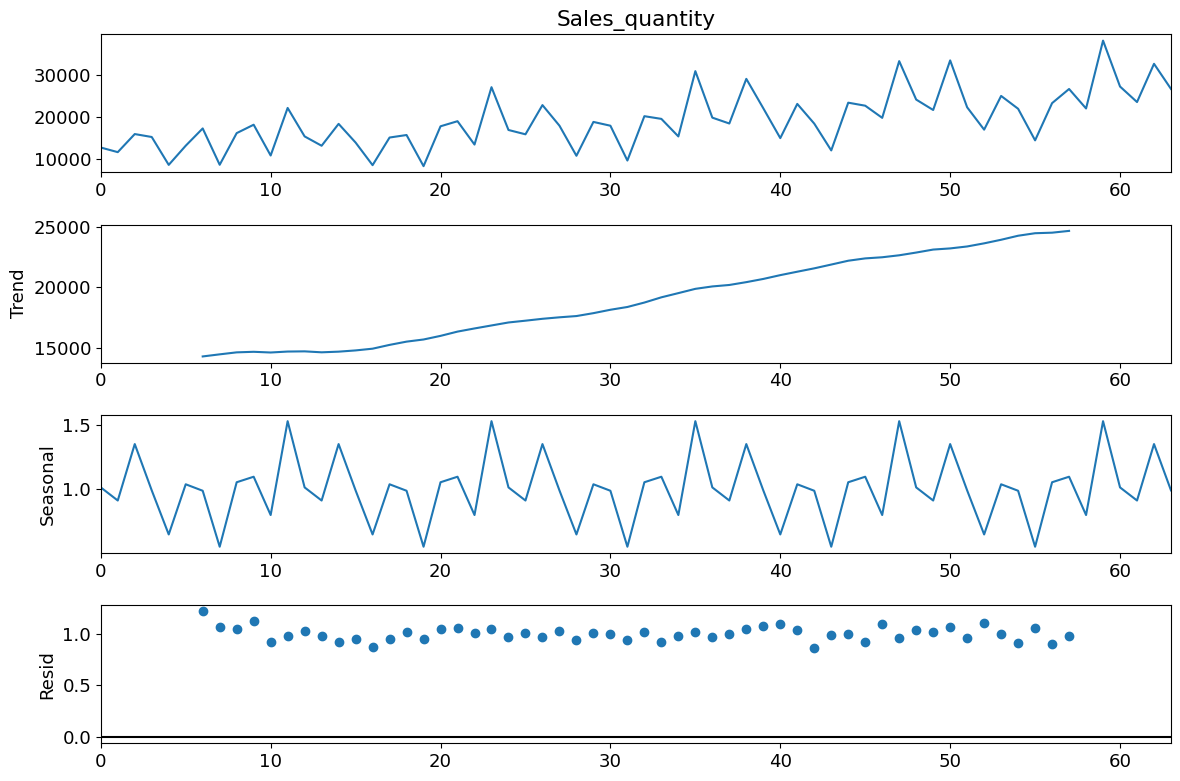

In [7]:
# Using statmodels: Subtracting the Trend Component
mult_result = seasonal_decompose(df['Sales_quantity'].dropna(), model='multiplicative', period=12)
mult_result.plot()
plt.show()

<AxesSubplot: >

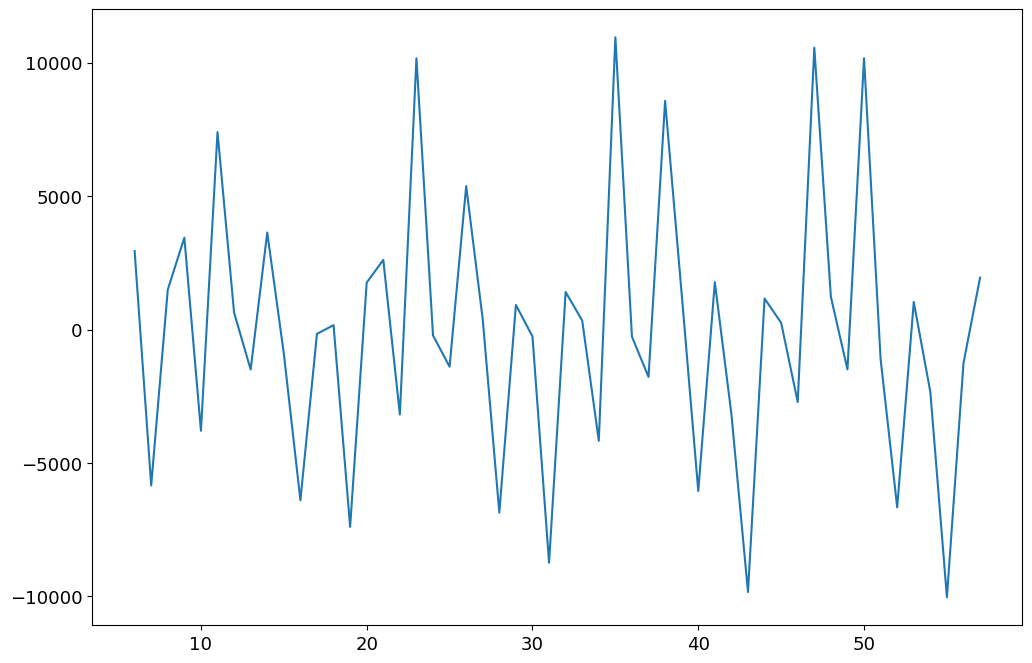

In [8]:
mult_detrended = df['Sales_quantity'].dropna().values - mult_result.trend
mult_detrended.plot()

From the decomposition above we can conclude:

1. There is a `upward trend` on sales. Therefore, this time series is `not stationary`.
2. From the seasonal component we can observe that the model is `additive`, since the seasonal component is similar (not getting multiplied) over the period of time.
3. Also we can observe on the seasonal component `seasonality` 


## Other Google Trends Data

Consider the search for the word "Diet" from the week starting at `2016-03-27` till week starting at `2021-03-21`.

In [9]:
diet = pd.read_csv("input/multiTimeline_diet.csv",skiprows=[0,1], index_col='Week', parse_dates=['Week'])
diet.head()

,diet: (United States)
Week,
2016-03-27,58
2016-04-03,63
2016-04-10,59
2016-04-17,59
2016-04-24,58


In [10]:
diet.describe()

,diet: (United States)
count,261.000000
mean,56.352490
std,11.499761
min,30.000000
25%,49.000000
50%,55.000000
75%,64.000000
max,100.000000


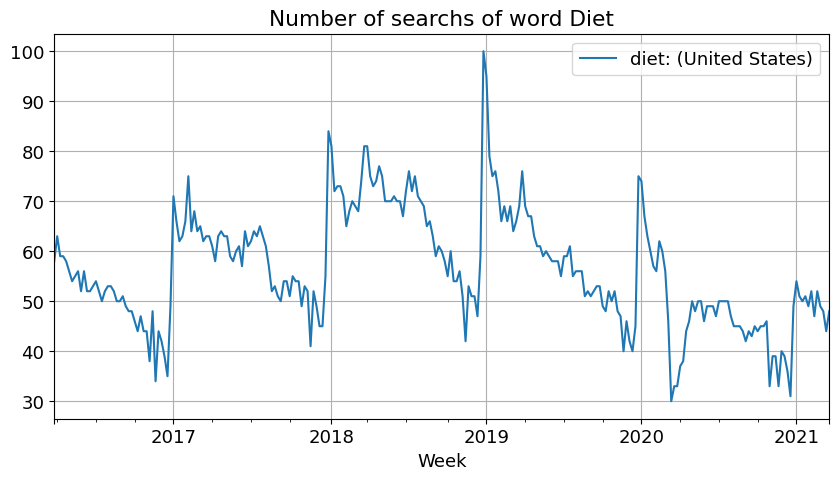

In [11]:
# Plot the entire time series diet and show gridlines
diet.plot(grid=True,figsize=(10,5), title = "Number of searchs of word Diet" )
plt.show()

The plot above shows a clear pattern: At the end of the year the word `Diet` has the lowest number of search while at the beginning of the year it has the highest number of searches. Do people at the end of the year just want to celebrate and enjoy good food? In consequence, do they choose as New Year’s resolution to become in good shape?

This time series has a `seasonal pattern`, i.e., it is influenced by seasonal factors. Seasonality occurs over a fixed and known period (e.g., the quarter of the year, the month, or day of the week). In this case the end of year festivities.

We can also observe that there is no constant increase or decrease in trend which would suggest a `non-linear trend`.

Let's decompose this time series in its components. Because we believe that trend is non-linear, we will set parameter `model` as multiplicative. By default, this parameter is additive.

Parameter `period` is optional but you can set it depending on the time series. Because the data is given in weeks, we set in period the number of weeks in a year.


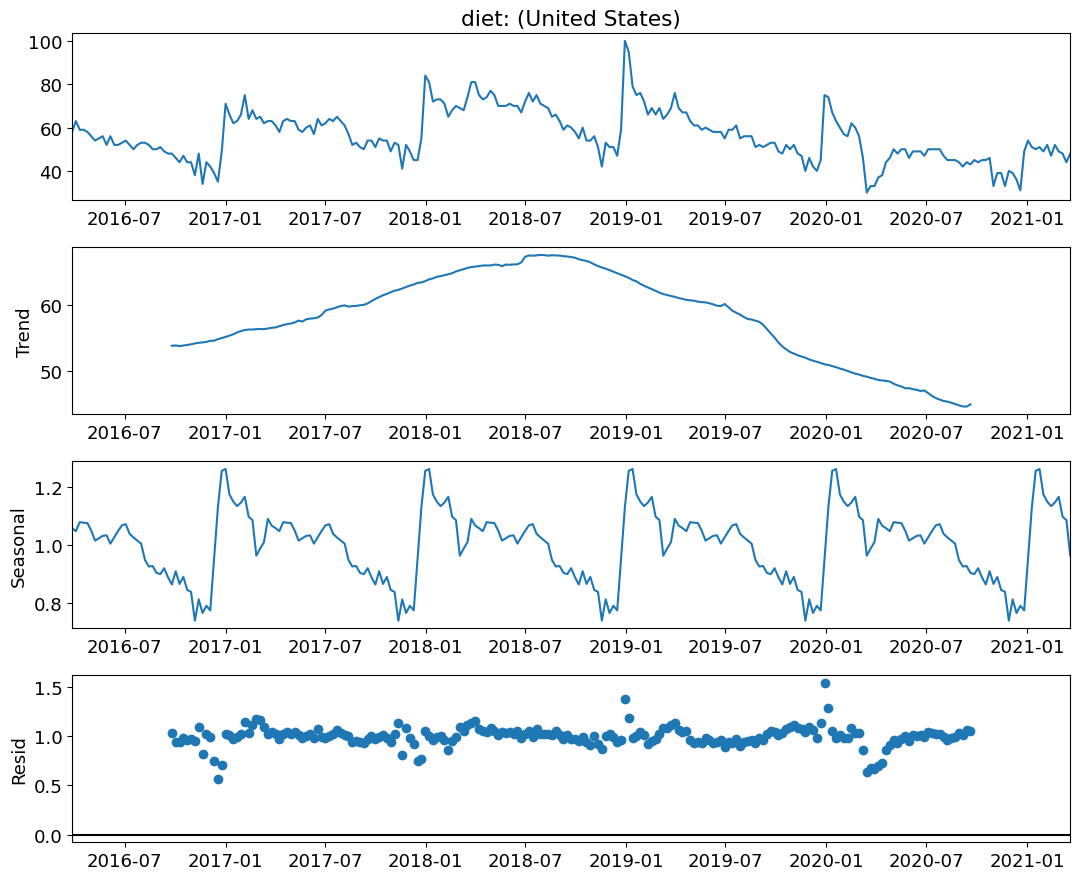

In [12]:
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9

import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(diet['diet: (United States)'],
                                         model = 'multiplicative',
                                         period=53 #52 to 53 weeks in a year
                                         )
fig = decomposition.plot()
plt.show()

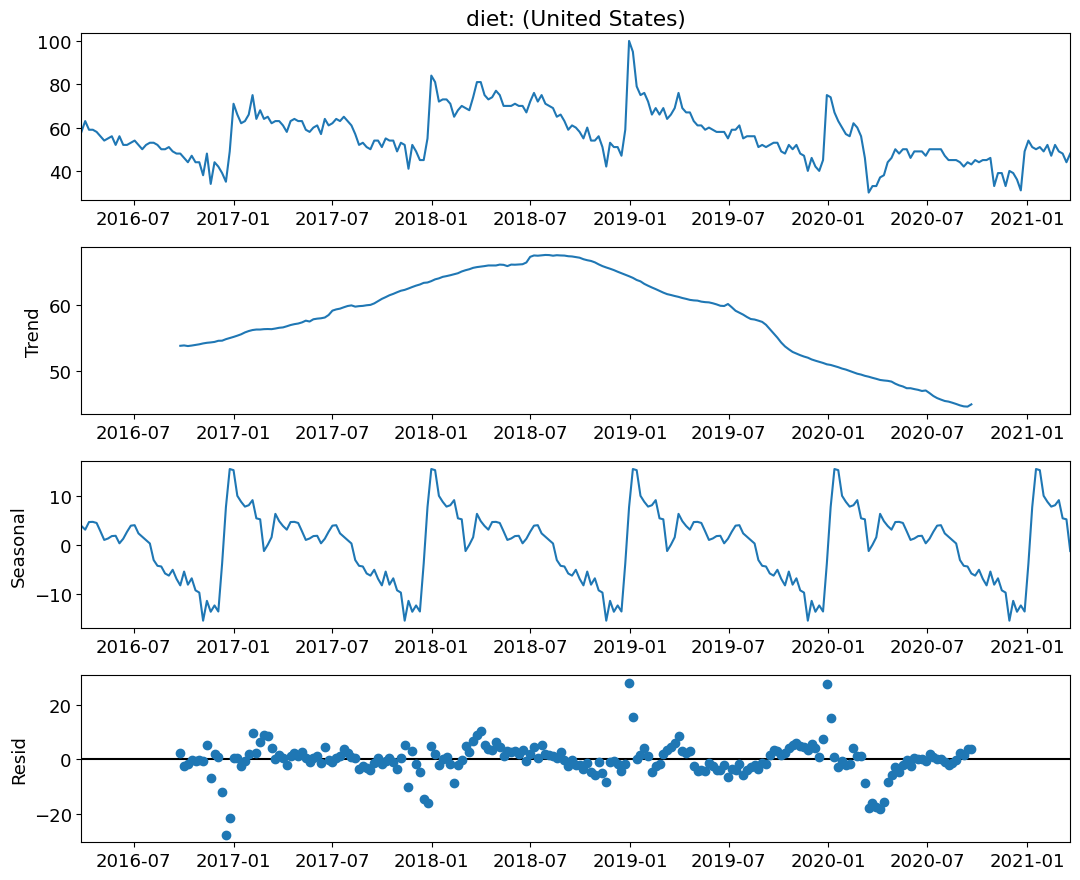

In [13]:
decomposition = sm.tsa.seasonal_decompose(diet['diet: (United States)'],
                                         model = 'additive',
                                         period=53 #52 to 53 weeks in a year
                                         )
fig = decomposition.plot()
plt.show()

As we suspected trend is non-linear. More than this, the time series follows no consistent upwards or downwards slope. Therefore, there is no positive (upwards slope) or negative (downwards slope) trend.

Also, if we compare multiplicative and additive residuals, we can see that the later is much smaller. As a result, a additive model (Trend + Seasonality) fits the original data much more closely.

Want to know more? Check this [interesting article](https://betterprogramming.pub/a-visual-guide-to-time-series-decomposition-analysis-a1472bb9c930) about performing additive and multiplicative decomposition.

# **3. Stationary in Time series data** <a class="anchor" id="3"></a>

Since our data is not stationary, we need to answer `What differencing will make it stationary? `. For this we will use our `obtain_adf_kpss_results` function to find out how many times we need to apply differencing in order to make this time series stationary. This will be our parameter `d` for the ARIMA model.


## 3.1 What is Stationary?

A stationary process is a process whose statistical properties do not change over time. More specifically, a stationary time series is one where the mean, variance, and autocorrelation structure are constant over time.

There are two types of stationarity: weak stationarity and strict stationarity. Weak stationarity requires that the mean, variance, and autocorrelation structure are constant over time, while strict stationarity requires that the probability distribution of the series is constant over time.

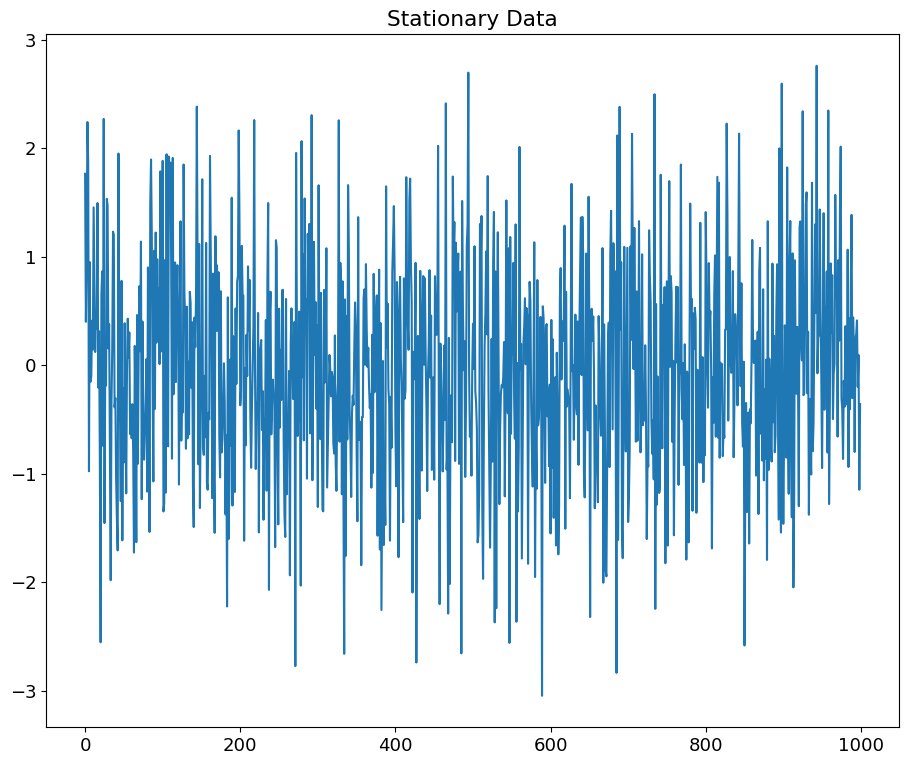

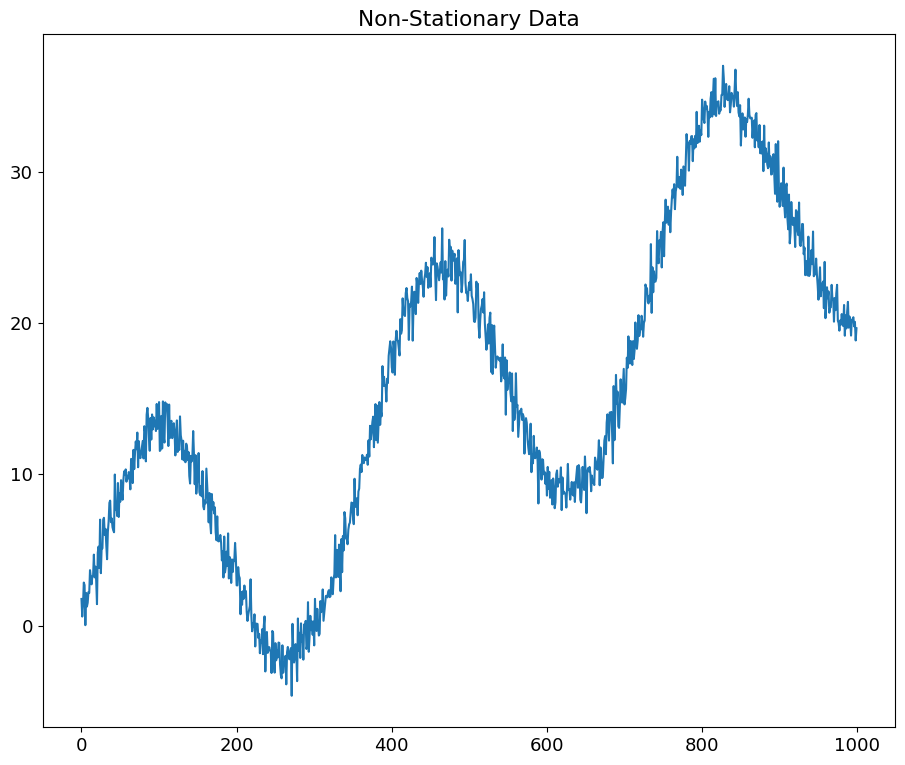

In [17]:
# Generate stationary time series data
np.random.seed(0)
stationary_data = np.random.normal(0, 1, size=1000)
plt.plot(stationary_data)
plt.title("Stationary Data")
plt.show()

# Generate non-stationary time series data
np.random.seed(0)
trend = 0.03 * np.arange(1000)
seasonality = 10 * np.sin(2 * np.pi * np.arange(1000) / 365)
noise = np.random.normal(0, 1, size=1000)
non_stationary_data = trend + seasonality + noise
plt.plot(non_stationary_data)
plt.title("Non-Stationary Data")
plt.show()


## 3.2 Importance of Stationary

Stationarity is important for several reasons:

- Easier to model: Stationary time series are much easier to model because their statistical properties are constant over time. This makes it easier to make forecasts, estimate parameters, and test hypotheses about the data.

- Better forecasting: Stationary time series are more predictable than non-stationary time series. Because their statistical properties are constant over time, we can use past data to make accurate predictions about future values.

- Valid statistical inference: When analyzing time series data, we often make inferences about the population based on a sample. However, for these inferences to be valid, the underlying time series process must be stationary. If the process is not stationary, statistical tests and confidence intervals will be unreliable.

- Avoid spurious relationships: Non-stationary time series can exhibit spurious relationships, where two variables appear to be related even though they are not. This can lead to false conclusions and poor forecasting performance.

Overall, stationarity is important in time series analysis because it simplifies modeling, improves forecasting accuracy, ensures valid statistical inference, and helps avoid spurious relationships.

## 3.3 Stationary test

#### <b>Augmented Dickey-Fuller Test</b>
A time series is said to be <i>“stationary”</i> if it has no trend, exhibits constant variance over time, and has a constant autocorrelation structure over time.
One way to test whether a time series is stationary is to perform an augmented Dickey-Fuller test, which uses the following null and alternative hypotheses:
<li>H0: The time series is non-stationary. In other words, it has some time-dependent structure and does not have constant variance over time.</li>
<li>HA: The time series is stationary.</li>

If the p-value from the test is less than some significance level (e.g. α = .05), then we can reject the null hypothesis and conclude that the time series is stationary.

#### <b>KPSS Test</b>
A KPSS test can be used to determine if a time series is trend stationary.This test uses the following null and alternative hypothesis:

<li>H0: The time series is trend stationary.</li>
<li>HA: The time series is not trend stationary.</li>

If the p-value of the test is less than some significance level (e.g. α = .05) then we reject the null hypothesis and conclude that the time series is not trend stationary.Otherwise, we fail to reject the null hypothesis.

When applying those tests the following outcomes are possible:

<li>Case 1: Both tests conclude that the series is **not stationary** - The series is 'not stationary`</li>
<li>Case 2: Both tests conclude that the series is **stationary** - The series is `stationary`</li>
<li>Case 3: KPSS indicates stationarity and ADF indicates non-stationarity - The series is `trend stationary`. Trend needs to be removed to make series strict stationary. The `detrended series` is checked for stationarity.</li>
<li>Case 4: KPSS indicates non-stationarity and ADF indicates stationarity - The series is `difference stationary`. `Differencing` is to be used to make series stationary. The differenced series is checked for stationarity.</li>

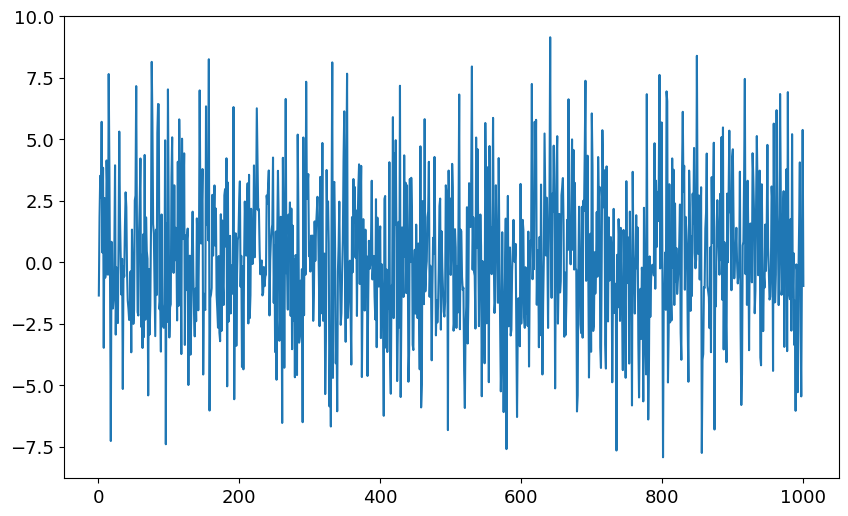

In [13]:
n = 1000
t = np.arange(1, 1001)
plt.plot(t,np.random.normal(scale=3, size=n))

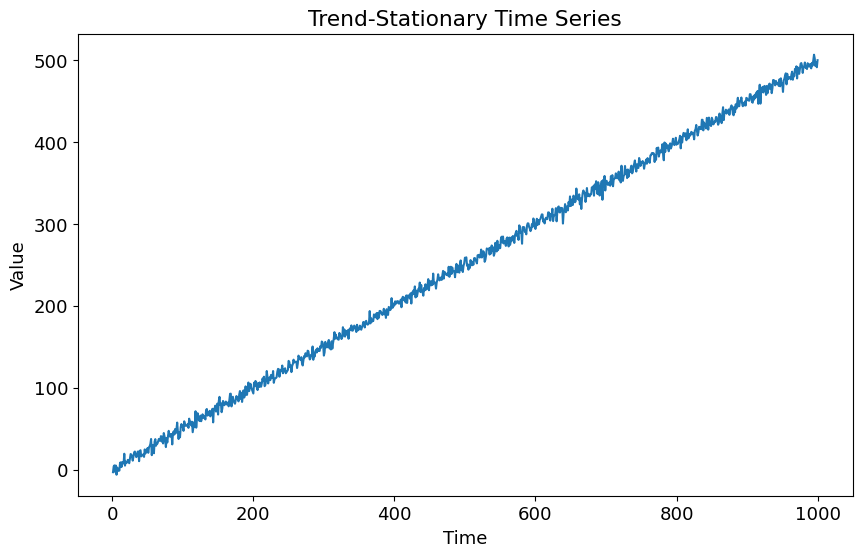

ADF Statistic: -0.16624701753374893
p-value: 0.9424271106036468
Critical Values: {'1%': -3.4370403176323214, '5%': -2.8644937368358425, '10%': -2.5683427207413576}


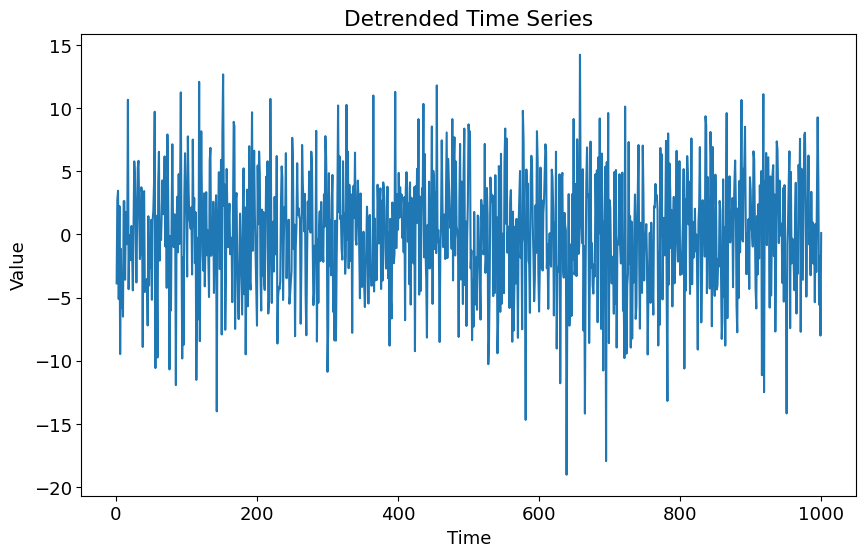

ADF Statistic: -20.458882512260033
p-value: 0.0
Critical Values: {'1%': -3.4369259442540416, '5%': -2.8644432969122833, '10%': -2.5683158550174094}


In [6]:
import statsmodels.api as sm

# Generate a trend-stationary time series (random walk with drift)
t = np.arange(1, n+1)
y = 0.5 * t + np.random.normal(scale=5, size=n)

# Plot the time series
plt.plot(t, y)
plt.title('Trend-Stationary Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

# Test for stationarity
res = sm.tsa.stattools.adfuller(y)
print('ADF Statistic:', res[0])
print('p-value:', res[1])
print('Critical Values:', res[4])

# Detrend the time series
y_detrended = sm.tsa.detrend(y)

# Plot the detrended time series
plt.plot(t, y_detrended)
plt.title('Detrended Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

# Test for stationarity of the detrended time series
res_detrended = sm.tsa.stattools.adfuller(y_detrended)
print('ADF Statistic:', res_detrended[0])
print('p-value:', res_detrended[1])
print('Critical Values:', res_detrended[4])


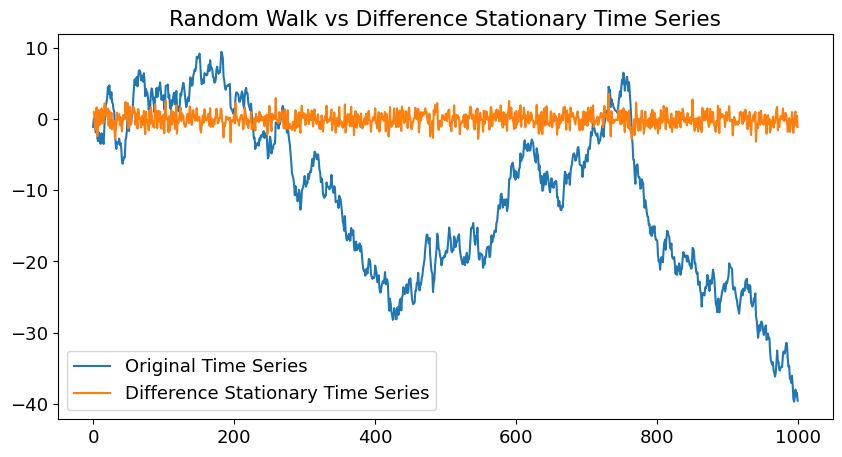

In [10]:
# Create a random walk time series without a drift
n = 1000
np.random.seed(123)
ts = pd.Series(np.random.randn(n).cumsum(), name='price')

# Create a difference stationary time series
diff_ts = ts.diff().dropna()

# Plot both time series for comparison
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(ts)
plt.plot(diff_ts)
plt.legend(['Original Time Series', 'Difference Stationary Time Series'])
plt.title('Random Walk vs Difference Stationary Time Series')
plt.show()


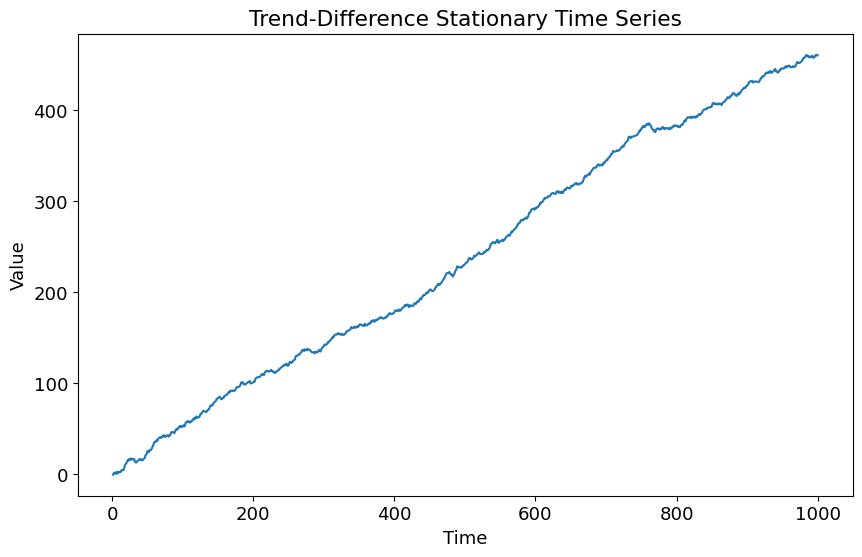

In [14]:
# Create a random walk time series without a drift
n = 1000
np.random.seed(123)
t = np.arange(1, n+1)
ts = pd.Series(0.5 * t +np.random.randn(n).cumsum(), name='price')

# Plot the time series
plt.plot(t,ts)
plt.title('Trend-Difference Stationary Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()


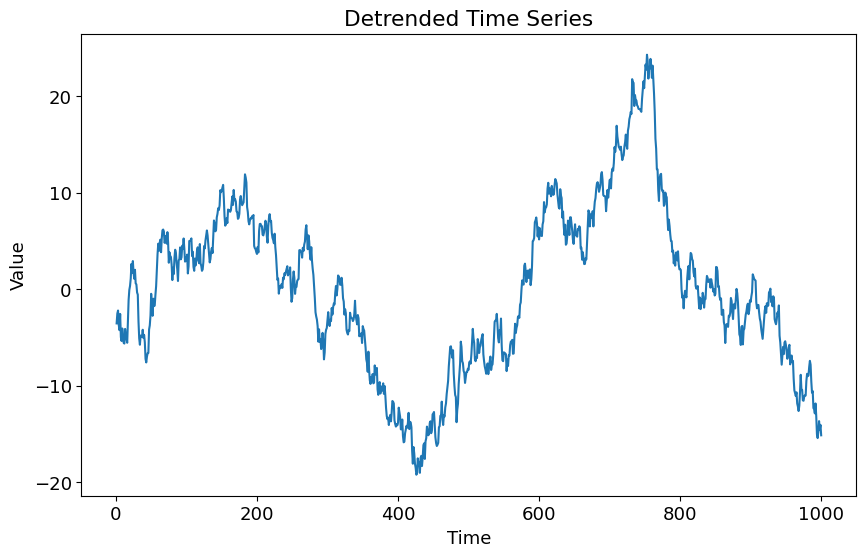

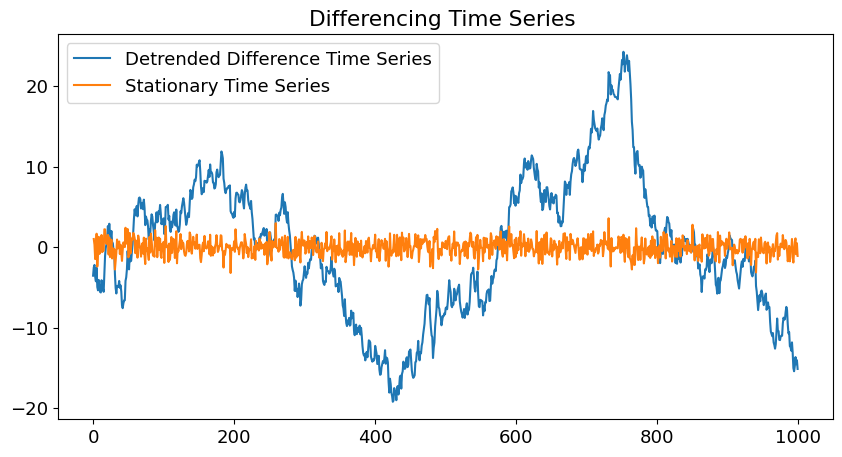

In [16]:
# Detrend the time series
ts_detrended = sm.tsa.detrend(ts)
# Create a difference stationary time series
diff_ts = ts_detrended.diff().dropna()

# Plot the detrended time series
plt.plot(t, ts_detrended)
plt.title('Detrended Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

# Plot both time series for comparison

plt.figure(figsize=(10,5))
plt.plot(ts_detrended)
plt.plot(diff_ts)
plt.legend(['Detrended Difference Time Series', 'Stationary Time Series'])
plt.title('Differencing Time Series ')
plt.show()



In [16]:
# Stationary testing with Sales data

results_df = obtain_adf_kpss_results(df['Sales_quantity'].dropna(), max_d=3)
results_df

c:\Users\thuduong\Anaconda3\envs\timeseries\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\Users\thuduong\Anaconda3\envs\timeseries\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\Users\thuduong\Anaconda3\envs\timeseries\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


,d,adf_stats,p-value,is_adf_stationary,is_kpss_stationary,is_stationary
0,0,9.956753e-01,0.01,False,False,False
1,1,5.708171e-15,0.10,True,True,True
2,2,1.850149e-11,0.10,True,True,True


Summing up, the analysis made so far shows that:

